<a href="https://colab.research.google.com/github/Jaeseong98/2019AIChem/blob/master/Final_Project_MPNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')



--2019-12-15 16:49:18--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
    - conda==4.7.12=py37_0
    - cryptography==2.8=py37h1ba5d50_0
    - idna==2.8=py37_0
    - libedit==3.1.20181209=hc058e9b_0
  

In [ ]:
# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
# !pip3 install torchvision
# ! pip install --verbose --no-cache-dir torch-scatter
# ! pip install --verbose --no-cache-dir torch-sparse
# ! pip install --verbose --no-cache-dir torch-cluster
# ! pip install --verbose --no-cache-dir torch-spline-conv
# ! pip install torch-geometric

#!pip install tensorboard_logger
import numpy as np
from numpy import linalg
import networkx as nx
import torch
import time
import random
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim.lr_scheduler as lrs
import math

import rdkit
from rdkit.Chem import AllChem 
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem.rdchem import HybridizationType
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.rdchem import BondType
from rdkit.Chem.rdMolTransforms import GetBondLength

import os
from os import listdir
import os.path as osp
from os.path import isfile, join

from six.moves import urllib
import errno
import tarfile
import tarfile
import multiprocessing
from joblib import Parallel, delayed

In [ ]:
#Process data set
def coalesce(index, value):
    n = index.max().item() + 1
    row, col = index
    unique, inv = torch.unique(row * n + col, sorted=True, return_inverse=True)

    perm = torch.arange(inv.size(0), dtype=inv.dtype, device=inv.device)
    perm = inv.new_empty(unique.size(0)).scatter_(0, inv, perm)
    index = torch.stack([row[perm], col[perm]], dim=0)
    value = value[perm]

    return index, value

def data_process():
    
  path = '/content/gdrive/My Drive/QM9'
  suppl = Chem.SDMolSupplier('{}/gdb9.sdf'.format(path))

  with open('{}/gdb9.sdf.csv'.format(path), 'r') as f:
      target = f.read().split('\n')[1:-1]
      n_target = []
      for line in target:
        x = line.split(',')
        n_target.append([float(x[11]), float(x[14])])
      target = n_target

  fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
  factory = ChemicalFeatures.BuildFeatureFactory(fdef_name)
  data_list = []

  for i, mol in enumerate(suppl):
    if mol is None:
        continue

    text = suppl.GetItemText(i)
    
    num_hs = []
    for atom in mol.GetAtoms():
        num_hs.append(atom.GetTotalNumHs())

    mol = Chem.AddHs(mol)
    feats = factory.GetFeaturesForMol(mol)

    H_type = []
    C_type = []
    N_type = []
    O_type = []
    F_type = []
    atomic_number = []
    sp = []
    sp2 = []
    sp3 = []
    aromatic = []
    acceptor = []
    donor = []

    # Example 130669 has an error and yields a different number of atoms.
    # We discard it.
    if i == 130669:
        continue

    num_atoms = mol.GetNumAtoms()

    if i%10000 is 0: print(i)
    
    pos = text.split('\n')[4:4 + num_atoms]
    pos = [[float(x) for x in line.split()[:3]] for line in pos]

    for j in range(num_atoms):
        atom = mol.GetAtomWithIdx(j)
        symbol = atom.GetSymbol()
        H_type.append(1 if symbol == 'H' else 0)
        C_type.append(1 if symbol == 'C' else 0)
        N_type.append(1 if symbol == 'N' else 0)
        O_type.append(1 if symbol == 'O' else 0)
        F_type.append(1 if symbol == 'F' else 0)
        atomic_number.append(atom.GetAtomicNum())
        hybridization = atom.GetHybridization()
        sp.append(1 if hybridization == HybridizationType.SP else 0)
        sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
        sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
        aromatic.append(1 if atom.GetIsAromatic() else 0)
        acceptor.append(0)
        donor.append(0)

        if symbol == 'H':
            num_hs.insert(j, 0)

    for j in range(0, len(feats)):
        if feats[j].GetFamily() == 'Donor':
            node_list = feats[j].GetAtomIds()
            for j in node_list:
                donor[j] = 1
        elif feats[j].GetFamily() == 'Acceptor':
            node_list = feats[j].GetAtomIds()
            for j in node_list:
                acceptor[j] = 1

    x = [
        H_type, C_type, N_type, O_type, F_type, atomic_number, acceptor, donor,
        aromatic, sp, sp2, sp3, num_hs
    ]
    x = np.asarray(x).transpose()
    pos = torch.tensor(pos, dtype=torch.float).numpy()
    y = np.asarray(target[i])

    chem, raw, bins = [], [], []
    step = (6-2)/8.0
    start = 2

    for v_i in range(0, num_atoms):
          for v_j in range(0, num_atoms):
              e_ij = mol.GetBondBetweenAtoms(v_i, v_j)

              feat = []

              if e_ij is not None :
                bond_type = e_ij.GetBondType()
                feat = [int(bond_type == x) for x in [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE,
                                                              rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC]]
              
              else:
                feat = [0, 0, 0, 0]
                
              dist = np.linalg.norm(pos[v_i]-pos[v_j])
              bin_feat = copy.deepcopy(feat)
              
              b = 9
              dist_bin = [0 for bin_iter in range(10)]
              for k in range(0, 9):
                  if dist < (start+k*step):
                      b = k
                      break
              
              dist_bin[b] = 1
              bin_feat = bin_feat + dist_bin
              bins.append(bin_feat)

    size = (num_atoms, num_atoms, -1)

    chem = np.asarray(chem).reshape(size)
    raw = np.asarray(raw).reshape(size)
    bins = np.asarray(bins).reshape(size)

    data_list.append({
        'x': torch.tensor(x),
        'y': torch.tensor(y),
        'bins': torch.tensor(bins),
    })

    
  torch.save(data_list, '/content/gdrive/My Drive/QM9/qm9.pt')

data_process()

qm9 = torch.load('/content/gdrive/My Drive/QM9/qm9.pt')
print(qm9[-1])
print(len(qm9))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
{'x': tensor([[0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 2],
        [0, 0, 1, 0, 0, 7, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 8, 1, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]), 'y': tensor([-400.6331, -400.6622], dtype=torch.float64), 'bins': tensor([[

In [ ]:
class Qm9(data.Dataset):

    # Constructor
    def __init__(self, data_list, ids, target_transform=None, e_representation='raw_distance'):
        self.data_list = data_list
        self.ids = ids
        self.target_transform = target_transform
        self.e_representation = e_representation

    def __getitem__(self, index):

        g = self.data_list[self.ids[index]]
        h = g['x']
        e = g['bins']
        target = g['y'][1]

        if self.target_transform is not None:
            target = self.target_transform(target)

        return (h, e, target)

    def __len__(self):
        return len(self.ids)

    def set_target_transform(self, target_transform):
        self.target_transform = target_transform

    def get_statics(self):

        targets = []
        for index in range(len(self.ids)):
          targets.append(self.data_list[self.ids[index]]['y'][1])
        targets = torch.stack(targets)

        return torch.mean(targets, dim=0), torch.std(targets, dim=0)

def collate_g(batch):

    batch_sizes = np.max(np.array([h.size(0) for (h, e, target) in batch]))

    h = np.zeros((len(batch), batch_sizes, 13))
    e = np.zeros((len(batch), batch_sizes, batch_sizes, 14))
    a = np.zeros((len(batch), batch_sizes, batch_sizes))
    #target = np.zeros((len(batch), 4))
    target = np.zeros((len(batch), 1))

    for i in range(len(batch)):

        num_nodes = batch[i][0].size(0)
        h[i, 0:num_nodes, :] = batch[i][0]
        e[i, 0:num_nodes, 0:num_nodes, :] = batch[i][1]

        # Target
        target[i, :] = batch[i][2]


    h = torch.FloatTensor(h)
    e = torch.FloatTensor(e)
    target = torch.FloatTensor(target)
    
    return h, e, target

def normalize_data(data, mean, std):
    data_norm = (data-mean)/std
    return data_norm


In [ ]:
class NNet(nn.Module):

    def __init__(self, n_in, n_out, hlayers=(128, 256, 128)):
        super(NNet, self).__init__()
        self.n_hlayers = len(hlayers)
        self.fcs = nn.ModuleList([nn.Linear(n_in, hlayers[i]) if i == 0 else
                                  nn.Linear(hlayers[i-1], n_out) if i == self.n_hlayers else
                                  nn.Linear(hlayers[i-1], hlayers[i]) for i in range(self.n_hlayers+1)])

    def forward(self, x):
        for i in range(self.n_hlayers):
            x = F.relu(self.fcs[i](x))
        x = self.fcs[-1](x)
        return x

In [ ]:
class Set2Set(nn.Module): 
    def __init__(self, input_dim, M, num_layers=1):
        super(Set2Set, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = input_dim*2
        self.num_layers = num_layers
        self.lstm_output_dim = input_dim
        self.lstm = nn.LSTM(input_dim*2, input_dim, num_layers=num_layers, batch_first=True)
        self.M = M

        self.pred = nn.Linear(input_dim*2, input_dim)
        self.act = nn.ReLU()

    def forward(self, embedding):
        batch_size = embedding.size()[0]
        n = embedding.size()[1]

        hidden = (torch.zeros(self.num_layers, batch_size, self.lstm_output_dim).cuda(),
                  torch.zeros(self.num_layers, batch_size, self.lstm_output_dim).cuda())

        q_star = torch.zeros(batch_size, 1, self.hidden_dim).cuda()

        for i in range(self.M):
            q, hidden = self.lstm(q_star, hidden)
            e = embedding @ torch.transpose(q, 1, 2)
            a = nn.Softmax(dim=1)(e)
            r = torch.sum(a * embedding, dim=1, keepdim=True)
            q_star = torch.cat((q, r), dim=2)
        q_star = torch.squeeze(q_star, dim=1)
        out = self.act(self.pred(q_star))

        return out

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(train_loader, model, criterion, optimizer, epoch, evaluation, logger=None):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    error_ratio = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()

    loss_list = []
    err_list = []

    for i, (h, e, target) in enumerate(train_loader):

        # Prepare input data
        h, e, target = h.cuda(), e.cuda(), target.cuda()

        # Measure data loading time
        data_time.update(time.time() - end)

        optimizer.zero_grad()

        # Compute output
        output = model(h, e)
        train_loss = criterion(output, target)
        eval_val = evaluation(output, target)

        loss_list.append(train_loss.item())
        err_list.append(eval_val.item())

        # Logs
        losses.update(train_loss.item(), h.size(0))
        error_ratio.update(eval_val, h.size(0))

        # compute gradient and do SGD step
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 300 == 0:

          print('outputs : ', output[0], target[0])

          print('Epoch: [{0}][{1}/{2}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'Error Ratio {err.val:.4f} ({err.avg:.4f})'
                .format(epoch, i, len(train_loader), batch_time=batch_time,
                        data_time=data_time, loss=losses, err=error_ratio))
        
    if logger is not None:
      logger.log_value('train_epoch_loss', losses.avg)
      logger.log_value('train_epoch_error_ratio', error_ratio.avg)

    print('Epoch: [{0}] Avg Error Ratio {err.avg:.3f}; Average Loss {loss.avg:.3f}; Avg Time x Batch {b_time.avg:.3f}'
          .format(epoch, err=error_ratio, loss=losses, b_time=batch_time))
    
    return loss_list, err_list


def validate(val_loader, model, criterion, evaluation, logger=None):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error_ratio = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (h, e, target) in enumerate(val_loader):

        # Prepare input data
        h, e, target = h.cuda(), e.cuda(), target.cuda()

        # Compute output
        output = model(h, e)

        # Logs
        losses.update(criterion(output, target).item(), h.size(0))
        error_ratio.update(evaluation(output, target).item(), h.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 300 == 0:

          print('Test: [{0}/{1}]\t'
                'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                'Error Ratio {err.val:.4f} ({err.avg:.4f})'
                .format(i, len(val_loader), batch_time=batch_time,
                        loss=losses, err=error_ratio))

    print(' * Average Error Ratio {err.avg:.3f}; Average Loss {loss.avg:.3f}'
          .format(err=error_ratio, loss=losses))

    if logger is not None:
        logger.log_value('test_epoch_loss', losses.avg)
        logger.log_value('test_epoch_error_ratio', error_ratio.avg)

    return error_ratio.avg, losses.avg

In [ ]:
print('Prepare files')

idx = np.random.permutation(133245)
idx = idx.tolist()
valid_ids = idx[0:10000]
test_ids = idx[10000:20000]
train_ids = idx[20000:]

# reduce num of dataset for debugging
# idx = np.random.permutation(10000)
# idx = idx.tolist()
# valid_ids = idx[0:1000]
# test_ids = idx[1000:2000]
# train_ids = idx[2000:]

data_train = Qm9(qm9, train_ids)
data_valid = Qm9(qm9, valid_ids)
data_test = Qm9(qm9, test_ids)

train_mean, train_std = data_train.get_statics()

data_train.set_target_transform(lambda x: normalize_data(x, train_mean, train_std))
data_valid.set_target_transform(lambda x: normalize_data(x, train_mean, train_std))
data_test.set_target_transform(lambda x: normalize_data(x, train_mean, train_std))

train_loader = torch.utils.data.DataLoader(data_train,
                                            batch_size=128, shuffle=True,
                                            collate_fn=collate_g,
                                            num_workers=2)
valid_loader = torch.utils.data.DataLoader(data_valid,
                                            batch_size=128, collate_fn=collate_g,
                                            num_workers=2)
test_loader = torch.utils.data.DataLoader(data_test,
                                          batch_size=128, collate_fn=collate_g,
                                          num_workers=2)


Prepare files


In [ ]:
class MessageFunction(nn.Module):
  def __init__(self, n_bond, n_atoms):
    super(MessageFunction, self).__init__()
    self.fcs = NNet(n_in=n_bond, n_out=(n_atoms*n_atoms), hlayers=[128])
    #self.fcs = nn.Linear(n_bond, n_atoms*n_atoms)
    self.n_bond = n_bond
    self.n_atoms = n_atoms
    
  #from w to v along e : m_wv
  def forward(self, h_w, e_vw):
    edge_output = self.fcs.forward(e_vw)
    edge_output = edge_output.view(edge_output.size(0), edge_output.size(1), self.n_atoms, self.n_atoms)
    h_w = torch.unsqueeze(h_w, 3)
    h_multiply =  torch.einsum('ijkk,ijkl->ijkl', [edge_output, h_w])
    m_new = torch.squeeze(h_multiply)

    return m_new


In [ ]:
class UpdateFunction(nn.Module):
  def __init__(self, n_atoms):
    super(UpdateFunction, self).__init__()
    self.rnn = nn.GRU(input_size=n_atoms, hidden_size=n_atoms)

  def forward(self, h_v, m_v):
    m_v = torch.unsqueeze(m_v, 1)
    h_v = torch.unsqueeze(h_v, 0)
    m_v = m_v.permute(1, 0, 2)
    h_v = h_v.contiguous()
    m_v = m_v.contiguous()
    output, h_n = self.rnn.forward(m_v, h_v)  # 0 or 1???
    return h_n.permute(1, 0, 2).squeeze()


In [ ]:
class ReadoutFunction(nn.Module):
  def __init__(self, hidden, node, l_target):
    super(ReadoutFunction, self).__init__()

    self.hidden = hidden
    self.node = node
    self.l_target = l_target
    # self.i = NNet(n_in=2*hidden, n_out=l_target, hlayers=[128])
    # self.j = NNet(n_in=hidden, n_out=l_target, hlayers=[128])

    # self.i = nn.Linear(2*hidden, l_target)
    # self.j = nn.Linear(hidden, l_target)

    # 1<=M<=12
    self.s2s = Set2Set(hidden+node, 6)
    self.out = NNet(hidden+node, l_target, hlayers=[128])

  def forward(self, h_t, x):

      # Equotion 4 in paper
      # i_out = nn.Sigmoid()(self.i(torch.cat([h_0, h_t], 2)))
      # j_out = self.j(h_t)
      # nn_res = i_out * j_out
      # ret = torch.sum(nn_res, 1)

      # set2set
      tup = torch.cat((h_t, x), dim=2)
      q_t = self.s2s.forward(tup)
      ret = self.out.forward(q_t)

      return ret

In [ ]:
class MPNN(nn.Module):
  def __init__(self, n_edge_feats, n_node_feats, n_hidden_feats, n_layers=3, n_towers=1,l_target=1):
    super(MPNN, self).__init__()
    self.m = nn.ModuleList([MessageFunction(n_edge_feats, n_hidden_feats // n_towers) 
                              for i in range(n_towers)])

    self.u = nn.ModuleList([UpdateFunction(n_hidden_feats // n_towers)
                              for i in range(n_towers)])

    self.r = ReadoutFunction(n_hidden_feats, n_node_feats, l_target)
    self.t = NNet(n_in=n_hidden_feats, n_out=n_hidden_feats, hlayers=[128])
    #self.t = nn.Linear(n_hidden_feats, n_hidden_feats)

    self.n_layers = n_layers
    self.l_target = l_target
    self.n_edge_feats = n_edge_feats
    self.n_node_feats = n_node_feats
    self.n_hidden_feats = n_hidden_feats
    self.n_towers = n_towers
    self.n_div_feats = n_hidden_feats // n_towers

    self.emb = nn.Linear(n_node_feats, n_hidden_feats)
    self.test = nn.Linear(n_hidden_feats, l_target)

  def forward(self, h_in, e):

    h = []
    # Padding to some larger dimension d
    h_0 = self.emb(h_in)
    h.append(h_0)

    # Layer
    for t in range(0, self.n_layers):

        h_t = torch.zeros(h_0.size(0), h_0.size(1), h_0.size(2)).cuda()
        # Apply one layer pass (Message + Update)
        for v in range(0, h_0.size(1)):
            for n in range(self.n_towers):

                # Message
                m = self.m[n].forward(h[t][:, :, self.n_div_feats*n : self.n_div_feats*(n+1)], e[:, v, :, :])

                # Update
                h_t[:, v, self.n_div_feats*n : self.n_div_feats*(n+1)] = self.u[n].forward(h[t][:, v, self.n_div_feats*n : self.n_div_feats*(n+1)], torch.sum(m, dim=1))
        
        if(self.n_towers != 1):
          h_t = self.t.forward(h_t)
        h.append(h_t)

    # Readout
    res = self.r.forward(h[-1], h_in)

    return res 


1e-05 0.7084268991346501
Optimizer 4.665169613845599e-08
outputs :  tensor([-0.0452], device='cuda:0', grad_fn=<SelectBackward>) tensor([-0.2550], device='cuda:0')
Epoch: [0][0/885]	Time 1.406 (1.406)	Data 0.476 (0.476)	Loss 1.0962 (1.0962)	Error Ratio 1.0009 (1.0009)
outputs :  tensor([-0.0417], device='cuda:0', grad_fn=<SelectBackward>) tensor([-0.6861], device='cuda:0')
Epoch: [0][300/885]	Time 0.267 (0.302)	Data 0.005 (0.007)	Loss 1.0275 (1.0052)	Error Ratio 0.9859 (0.9926)
outputs :  tensor([0.0656], device='cuda:0', grad_fn=<SelectBackward>) tensor([1.5034], device='cuda:0')
Epoch: [0][600/885]	Time 0.271 (0.293)	Data 0.005 (0.006)	Loss 0.9751 (0.9779)	Error Ratio 0.9342 (0.9845)
Epoch: [0] Avg Error Ratio 0.969; Average Loss 0.931; Avg Time x Batch 0.291
Test: [0/79]	Time 0.598 (0.598)	Loss 0.4851 (0.4851)	Error Ratio 0.7681 (0.7681)
 * Average Error Ratio 0.934; Average Loss 0.641
0.9342654598236084 0


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MPNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MessageFunction. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type NNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.

outputs :  tensor([-0.0399], device='cuda:0', grad_fn=<SelectBackward>) tensor([1.7102], device='cuda:0')
Epoch: [1][0/885]	Time 0.750 (0.750)	Data 0.402 (0.402)	Loss 0.6139 (0.6139)	Error Ratio 0.7617 (0.7617)
outputs :  tensor([-0.4858], device='cuda:0', grad_fn=<SelectBackward>) tensor([-0.6858], device='cuda:0')
Epoch: [1][300/885]	Time 0.317 (0.294)	Data 0.005 (0.006)	Loss 0.2417 (0.4271)	Error Ratio 0.8121 (0.8127)
outputs :  tensor([0.6112], device='cuda:0', grad_fn=<SelectBackward>) tensor([0.2400], device='cuda:0')
Epoch: [1][600/885]	Time 0.302 (0.291)	Data 0.004 (0.005)	Loss 0.2732 (0.3402)	Error Ratio 0.8084 (0.7772)
Epoch: [1] Avg Error Ratio 0.758; Average Loss 0.294; Avg Time x Batch 0.289
Test: [0/79]	Time 0.601 (0.601)	Loss 0.0378 (0.0378)	Error Ratio 0.2447 (0.2447)
 * Average Error Ratio 0.742; Average Loss 0.187
0.7418639715194703 1
outputs :  tensor([-0.2604], device='cuda:0', grad_fn=<SelectBackward>) tensor([-0.6560], device='cuda:0')
Epoch: [2][0/885]	Time 0.771

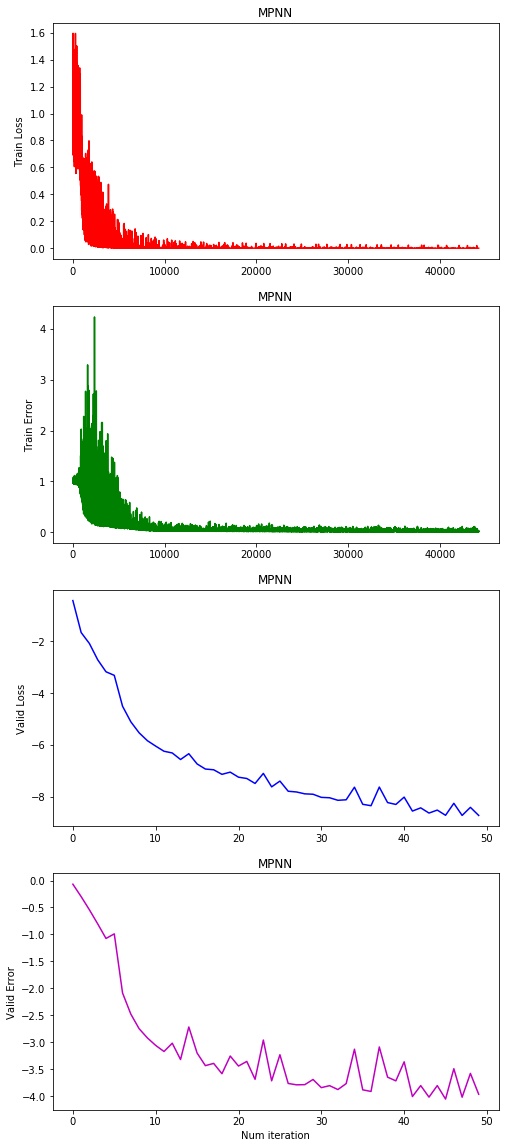

In [ ]:
model = MPNN(n_edge_feats=14, n_node_feats=13, n_hidden_feats=64, n_layers=3, n_towers=2, l_target=1)

#model = torch.load('/content/gdrive/My Drive/QM9/model_best.pt')

epochs = 50


# lr = random.uniform(1e-5, 5e-4)
lr = 1e-5
final = random.uniform(0.01, 1.0)
print(lr, final)
f_lr = lr * final
lr_step = (lr - f_lr) / epochs * 0.8
print('Optimizer' , str(lr_step))
lambda1 = lambda epoch: lr - (epoch - 0.1*epochs)*lr_step

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
evaluation = lambda output, target: torch.mean(torch.abs(output - target) / torch.abs(target))


model = model.cuda()
criterion = criterion.cuda()

best_er1 = 100

train_losses = []
train_errs = []
valid_losses = []
valid_errs = []


# Epoch for loop
for epoch in range(0, epochs):

    # train for one epoch
    train_loss, train_err = train(train_loader, model, criterion, optimizer, epoch, evaluation)

    
    train_losses.append(train_loss)
    train_errs.append(train_err)

    # evaluate on test set
    er1, valid_loss = validate(valid_loader, model, criterion, evaluation)

    valid_errs.append(math.log(er1))
    valid_losses.append(math.log(valid_loss))


    if epoch > epochs * 0.1 and epoch < epochs * 0.9:
      lr -= lr_step
      for param_group in optimizer.param_groups:
          param_group['lr'] = lr

    if er1 < best_er1:
      best_er1 = er1
      print(best_er1, epoch)
      torch.save(model, '/content/gdrive/My Drive/QM9/mpnn_model_tower.pt')
    
# For testing
test_err, _= validate(test_loader, model, criterion, evaluation)


import matplotlib.pyplot as plt

concat_train_loss = sum(train_losses, [])
concat_train_err = sum(train_errs, [])


plt.figure(figsize=(8, 20))
plt.subplot(4, 1, 1)
plt.plot(concat_train_loss, 'r')
plt.title('MPNN')
plt.ylabel('Train Loss')

plt.subplot(4, 1, 2)
plt.plot(concat_train_err, 'g')
plt.title('MPNN')
plt.ylabel('Train Error')

plt.subplot(4, 1, 3)
plt.plot(valid_losses, 'b')
plt.title('MPNN')
plt.ylabel('Valid Loss')

plt.subplot(4, 1, 4)
plt.plot(valid_errs, 'm')
plt.title('MPNN')
plt.ylabel('Valid Error')
plt.xlabel('Num iteration')

print(test_err)

In [ ]:
print(test_err)

0.018672386306524277
